# Usage of multinmrfit package

### Prepare environment

- Download and install Anaconda (>= 3.7) on your computer: https://www.anaconda.com/distribution/
- Install `multinmrfit`:
  - run `Anaconda prompt` from the start menu
  - install multinmrfit with: `python -m pip install git+https://github.com/NMRTeamTBI/MultiNMRFit.git@branch_name` (where `branch_name` is the git branch you want to install)
- Start Jupyter from the start menu
- Open the jupyter notbook

Load some packages.

In [68]:
import logging
import sys
import pandas as pd

Initialize logger.

In [69]:
logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s', level=logging.DEBUG, stream=sys.stdout)

Load multinmrfit.

In [70]:
import multinmrfit.base.spectrum as spectrum
import multinmrfit.base.io as io

## Load models.

Load models of signals implemented in multinmrfit.

In [71]:
available_models = io.IoHandler.get_models()

2023-01-09 17:09:47,873 | DEBUG : add model from file 'model_doublet.py'
2023-01-09 17:09:47,875 | DEBUG : model name: doublet
2023-01-09 17:09:47,876 | DEBUG : add model from file 'model_singlet.py'
2023-01-09 17:09:47,878 | DEBUG : model name: singlet
2023-01-09 17:09:47,879 | DEBUG : add model from file 'model_triplet.py'
2023-01-09 17:09:47,879 | DEBUG : model name: triplet


`io.IoHandler.get_models()` returns a dict with model_name-model_object as key-value pairs.

In [72]:
available_models.keys()

dict_keys(['doublet', 'singlet', 'triplet'])

In [73]:
available_models["doublet"]

multinmrfit.models.model_doublet.SignalModel

## Load NMR data.

Data can be loaded from a TSV file containing columns 'ppm' and 'intensity'.

In [74]:
test_synthetic_dataset = pd.read_table("./data/data_sim_nmrfit.csv", sep="\t")

In [75]:
test_synthetic_dataset.columns

Index(['ppm', 'intensity'], dtype='object')

Data can also be loaded from TopSpin files by providing all required information in a dictionnary, assuming one-dimensional spectrum if rowno is None or two-dimensional spectrum if rowno is provided.

In [76]:
test_topspin_dataset = {"data_path":"C:/Bruker/TopSpin4.0.7/data",
                        "dataset":"CFE_test",
                        "expno":"991",
                        "procno":"1",
                        "rowno":"3"}

The window of interest can be provided as a tuple containing lower and upper boundaries.

In [77]:
window = (-0.2, 0.2)

We can then load the data in a `Spectrum` object.

In [78]:
sp = spectrum.Spectrum(data=test_synthetic_dataset, window=window)

2023-01-09 17:09:47,994 | DEBUG : create Spectrum object


We can then work directly with the spectrum object. For instance, to view the experimental spectrum, use the `plot()` method with exp=True.

In [79]:
fig = sp.plot(exp=True)

2023-01-09 17:09:48,014 | DEBUG : create plot


This method returns a `plotly.graph_objects.Figure` object that can be updated (e.g. to change the layout) and plotted.

In [80]:
type(fig)

plotly.graph_objs._figure.Figure

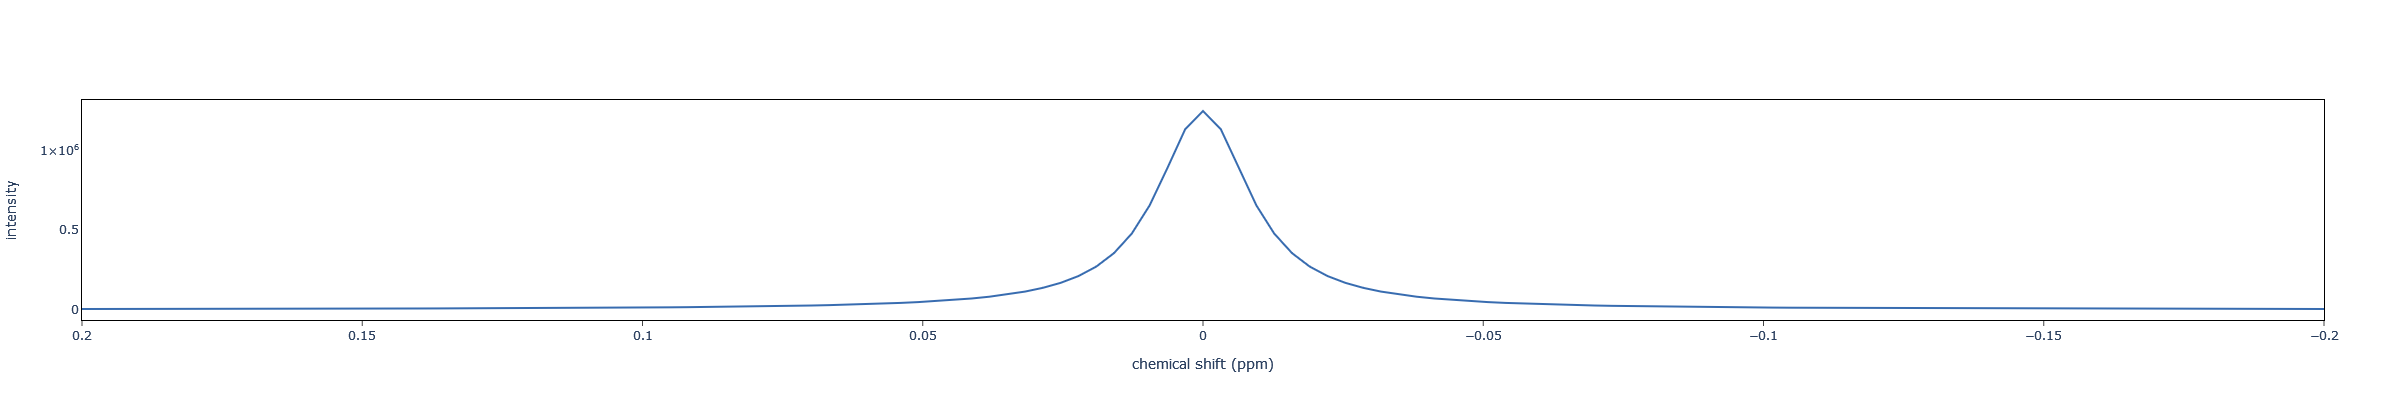

In [81]:
fig.update_layout(autosize=False, width=900, height=400)
fig.show()

## Peak picking.

Use the `peak_picking()` method with the `threshold` provided as argument.

In [82]:
peak_table = sp.peak_picking(1e6)

2023-01-09 17:09:48,082 | DEBUG : peak peaking
2023-01-09 17:09:48,087 | DEBUG : peak table
      intensity  ppm  X_AXIS  cID  X_LW           VOL
0  1.250091e+06  0.0    63.0    1   2.0  3.521388e+06


To visualize the spectrum and the identified peaks, use the `plot()` method with the `peak_table` provided as argument `pp`.

In [83]:
fig = sp.plot(pp=peak_table)

2023-01-09 17:09:48,100 | DEBUG : create plot


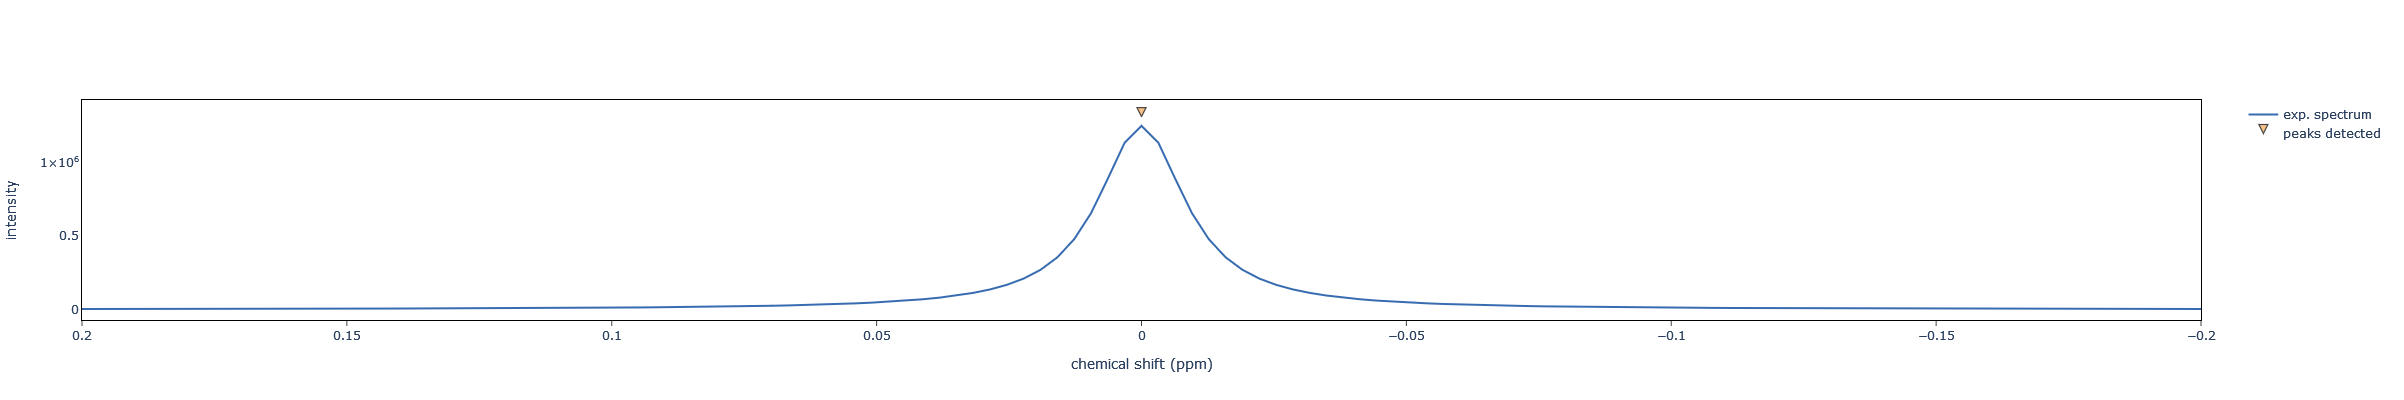

In [84]:
fig.update_layout(autosize=False, width=900, height=400)
fig.show()

## Spectrum simulation and fitting.

### Model construction

To simulate or fit a spectrum, we need to provide a list of signals containing the type of signal (e.g. singlet or doublet) and the corresponding parameters (chemical shift, coupling constant, linewidth, intensity, etc). Signals must be provided as a dictionary.

In [85]:


signals = {"singlet_TSP": {"model":"singlet", "par": {"x0": {"ini":0.0, "lb":-0.05, "ub":0.05}}}}

#signals = {"singlet_TSP": {"model":"singlet", "par": {"x0": {"ini":0.0, "lb":-0.05, "ub":0.05}}},
#           "doublet_TSP": {"model":"doublet", "par": {"x0": {"ini":-0.01, "lb":-0.01, "ub":0.01}, "J": {"ini":0.147, "lb":0.14, "ub":0.15}, "lw": {"ini":0.001}}}}


Then we can build a model of the spectrum with the `build_model()` method.

In [86]:
sp.build_model(signals=signals, available_models=available_models)

2023-01-09 17:09:48,159 | DEBUG : build Model for signal 'singlet_TSP'
2023-01-09 17:09:48,163 | DEBUG : parameters
     signal_id    model        par         ini     lb            ub
0  singlet_TSP  singlet         x0        1.00  0.000  1.000000e+01
1  singlet_TSP  singlet  intensity  1000000.00  1.000  1.000000e+15
2  singlet_TSP  singlet         lw        0.01  0.001  3.000000e-02
3  singlet_TSP  singlet         gl        0.50  0.000  1.000000e+00


Parameters can be accessed via the `params` attibute.

In [87]:
sp.params

,signal_id,model,par,ini,lb,ub
0,singlet_TSP,singlet,x0,0.00,-0.050,5.000000e-02
1,singlet_TSP,singlet,intensity,1000000.00,1.000,1.000000e+15
2,singlet_TSP,singlet,lw,0.01,0.001,3.000000e-02
3,singlet_TSP,singlet,gl,0.50,0.000,1.000000e+00


We can update parameters and offser using the update_params() method.

In [88]:
sp.update_params({"singlet_TSP": {"par": {"intensity": {"ini":1e6, "ub":1e12}}}})

Similarly, we can update the offset with the `update_offset()` method. If `offset=None`, the offset is removed. To set an offset, provide a dictionary (if empty, offset is initialized to default values).

In [89]:
sp.update_offset(offset={})
print(sp.params)

       signal_id    model        par         ini             lb            ub
0    singlet_TSP  singlet         x0        0.00      -0.050000  5.000000e-02
1    singlet_TSP  singlet  intensity  1000000.00       1.000000  1.000000e+12
2    singlet_TSP  singlet         lw        0.01       0.001000  3.000000e-02
3    singlet_TSP  singlet         gl        0.50       0.000000  1.000000e+00
4  full_spectrum     None     offset        0.00 -250018.225728  2.500182e+05


In [90]:
sp.update_offset(offset=None)
print(sp.params)

     signal_id    model        par         ini     lb            ub
0  singlet_TSP  singlet         x0        0.00 -0.050  5.000000e-02
1  singlet_TSP  singlet  intensity  1000000.00  1.000  1.000000e+12
2  singlet_TSP  singlet         lw        0.01  0.001  3.000000e-02
3  singlet_TSP  singlet         gl        0.50  0.000  1.000000e+00


### Simulation

Simulate spectrum using the `simulate()` method which returns a list of simulated intensities. If `params` is not given as argument, initial parameters values are used.

In [103]:
sim_spectrum = sp.simulate()

In [104]:
display(sim_spectrum)

0      1246.882793
1      1287.324797
2      1329.764958
3      1374.336984
4      1421.185947
          ...     
122    1421.185947
123    1374.336984
124    1329.764958
125    1287.324797
126    1246.882793
Name: ppm, Length: 127, dtype: float64

To view the spectrum simulated from initial values, just use the `plot()` method.

2023-01-10 09:57:07,496 | DEBUG : create plot


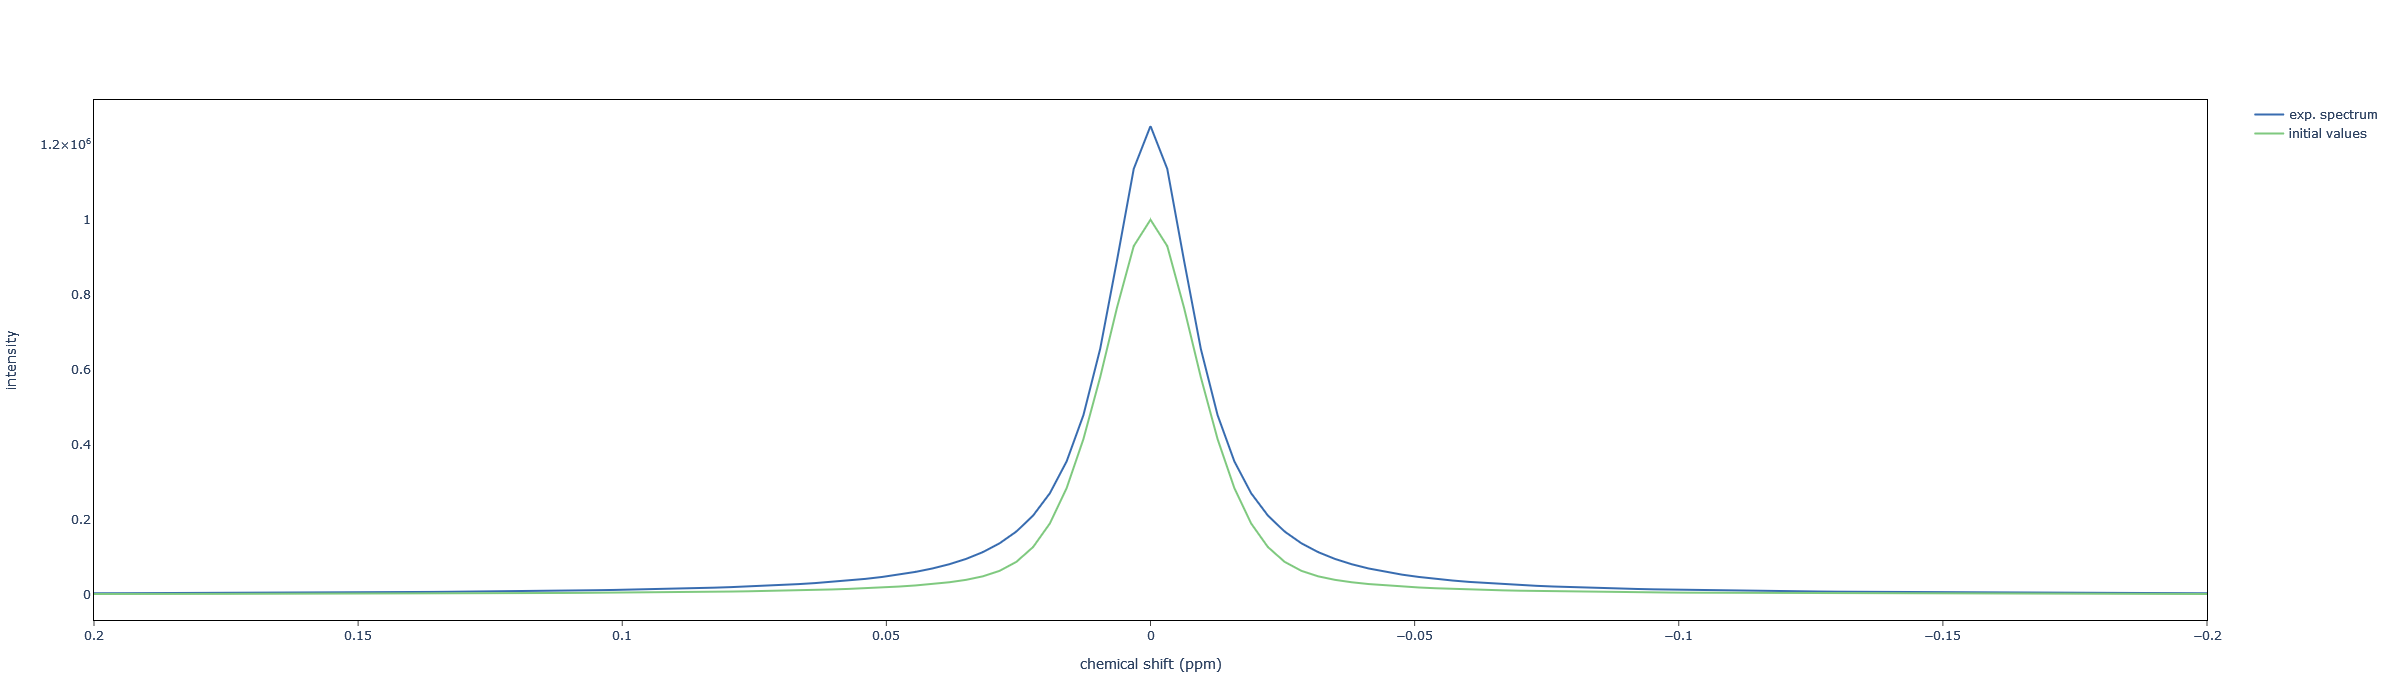

In [107]:
fig = sp.plot(ini=True)
fig.update_layout(autosize=False, width=900, height=700)
fig.show()

### Fitting

To fit experimental spectrum, use the `fit()` method.

In [91]:
sp.fit()

2023-01-09 17:09:48,239 | DEBUG : fit spectrum
2023-01-09 17:09:48,781 | DEBUG : parameters
     signal_id    model        par         ini     lb            ub  \
0  singlet_TSP  singlet         x0        0.00 -0.050  5.000000e-02   
1  singlet_TSP  singlet  intensity  1000000.00  1.000  1.000000e+12   
2  singlet_TSP  singlet         lw        0.01  0.001  3.000000e-02   
3  singlet_TSP  singlet         gl        0.50  0.000  1.000000e+00   

            opt      opt_sd     integral  
0  2.167009e-09    0.000002  39278.96044  
1  1.250012e+06  126.987515  39278.96044  
2  1.000263e-02    0.000008  39278.96044  
3  1.000000e+00    0.001138  39278.96044  


Estimated parameters, standard deviations and integrals are now in the params attributes (columns `opt`, `opt_sd` and `integral`, respectively).

In [92]:
sp.params

,signal_id,model,par,ini,lb,ub,opt,opt_sd,integral
0,singlet_TSP,singlet,x0,0.00,-0.050,5.000000e-02,2.167009e-09,0.000002,39278.96044
1,singlet_TSP,singlet,intensity,1000000.00,1.000,1.000000e+12,1.250012e+06,126.987515,39278.96044
2,singlet_TSP,singlet,lw,0.01,0.001,3.000000e-02,1.000263e-02,0.000008,39278.96044
3,singlet_TSP,singlet,gl,0.50,0.000,1.000000e+00,1.000000e+00,0.001138,39278.96044


Fitting results can be viewed using the plot method with fit=True.

2023-01-09 17:09:48,817 | DEBUG : create plot


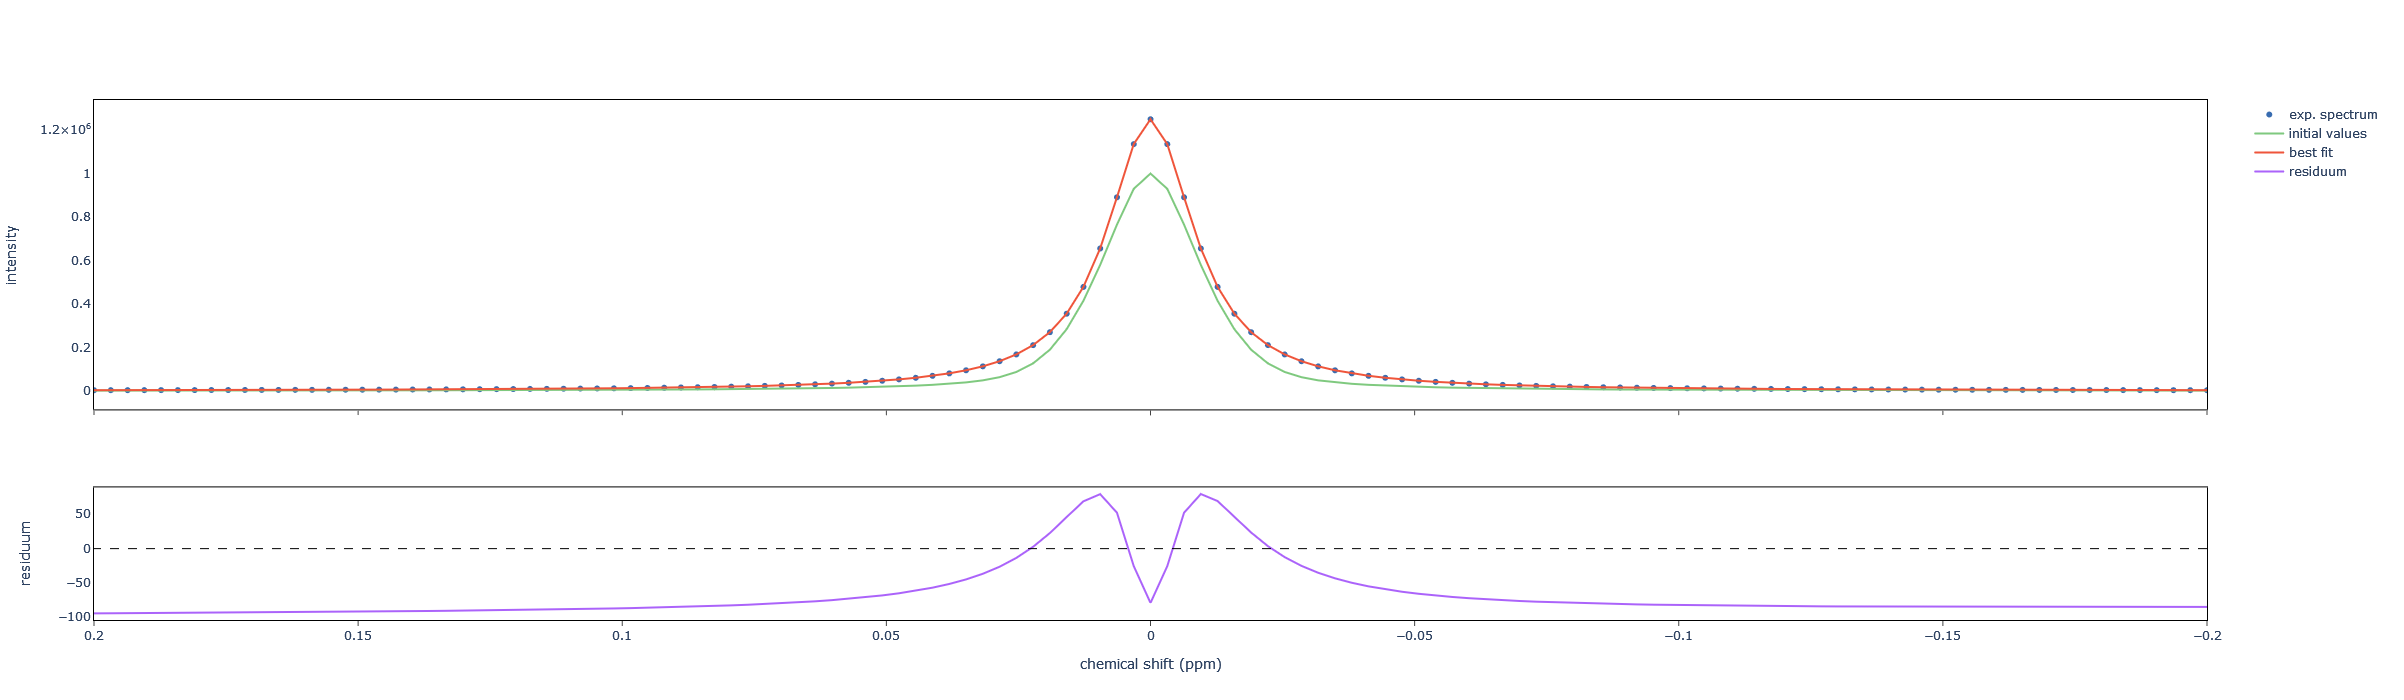

In [93]:
fig = sp.plot(ini=True, fit=True)
fig.update_layout(autosize=False, width=900, height=700)
fig.show()